In [135]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import math

In [98]:
def connectLines(cp, pt1, pt2):
    mat = np.copy(cp)
    x1, y1 = pt1
    x2, y2 = pt2
    
    dx = x2-x1
    dy = y2-y1
    
    count = 0
    sx = np.sign(dx)
    sy = np.sign(dy)
    vec = [dx , dy]
    # print(vec)
    sumV = abs(dx) + abs(dy)
    ratioX = abs(vec[0]/sumV)
    ratioY = abs(vec[1]/sumV)

    while dx != 0 or dy != 0:
        r = random.random()
        # print(f"r = {r}")
        if r < ratioX and dx:
            mat[x1+dx][y1+dy] = 255
            count += 1
            dx -= sx
            # print(f"xdir: {x1+dx}")
        elif dy:
            mat[x1+dx][y1+dy] = 255
            count += 1
            dy -= sy
            # print(f"ydir {y1+dy}")
    # print(60*"*")
    # print("Final Image")
    # print(60*"*")
    # print(mat)
    # print(count)
    return mat

In [99]:
def drawLine(cp, start, end):
    arr = np.copy(cp)
    y1, x1 = start
    y2, x2 = end
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    x, y = x1, y1
    sx = -1 if x1 > x2 else 1
    sy = -1 if y1 > y2 else 1

    if dx > dy:
        err = dx / 2.0
        while x != x2:
            arr[y][x] = 255
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y2:
            arr[y][x] = 255
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    arr[y][x] = 255
    return arr

In [100]:
def storeVals(img):
    mapping = []
    for i, row in enumerate(img):
        for j, pix in enumerate(row):
            if pix:
                mapping.append((i, j))
    return mapping


In [153]:
def pixelWipe(orig, cutoff):
    img = np.copy(orig)
    if len(img.shape) != 2:
        print("Image must be a 2D array")
        return
    else:
        for i, row in enumerate(img):
            for j, pix in enumerate(row):
                if pix and (random.random() > cutoff):
                    img[i][j] = 0
        return img
                    
                

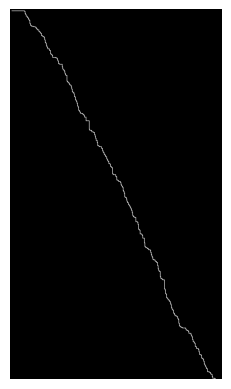

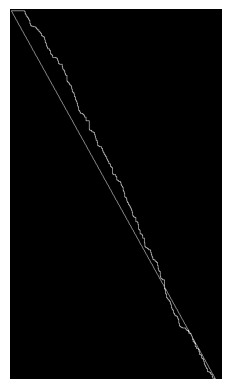

In [102]:
a = np.zeros((700,400), int)
pt1 = (3, 2)
pt2 = (699, 387)
a[pt1] = 1
a[pt2] = 1
a = connectLines(a, pt1, pt2)
plt.imshow(a, cmap='gray')
plt.axis('off')
plt.show()

a = drawLine(a, pt1, pt2)
plt.imshow(a, cmap='gray')
plt.axis('off')
plt.show()

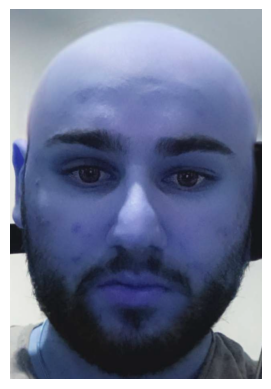

In [199]:
img = cv2.imread('./jognBald_cropped.jpg')
# img = cv2.bitwise_not(img)
plt.imshow(img)
plt.axis('off')
plt.show()

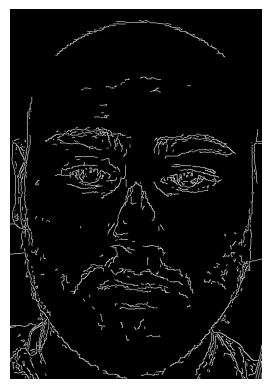

In [213]:
t_lower = 55  
t_upper = 40 

edge = cv2.Canny(img, t_lower, t_upper,  L2gradient = True)
plt.imshow(edge, cmap='gray')
plt.axis('off')
plt.show()

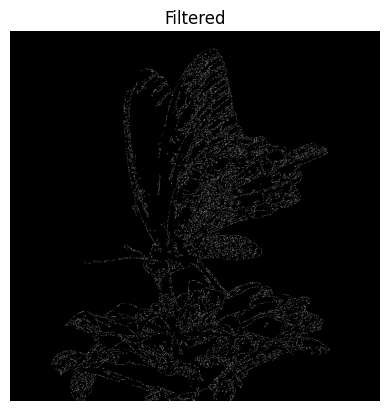

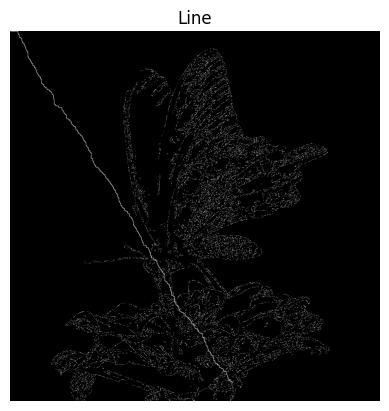

255


In [105]:
filt = pixelWipe(edge, 0.01)
plt.imshow(cv2.cvtColor(filt, cv2.COLOR_BGR2RGB))
plt.title("Filtered")
plt.axis(False)
plt.show()

line = connectLines(filt, (0, 0), (950, 600))
plt.imshow(cv2.cvtColor(line, cv2.COLOR_BGR2RGB))
plt.title("Line")
plt.axis(False)
plt.show()

print(np.max(line))

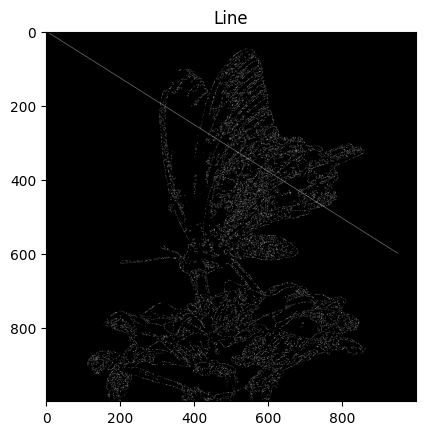

In [60]:
ret,thresh1 = cv2.threshold(filt,127,255,cv2.THRESH_BINARY)
plt.imshow(cv2.cvtColor(thresh1, cv2.COLOR_BGR2RGB))
plt.title("Line")
plt.axis(True)
plt.show()
# print(thresh1)

In [84]:
line = connectLines(filt, (0, 0), (950, 600))
plt.imshow(cv2.cvtColor(line, cv2.COLOR_BGR2RGB))
plt.title("Line")
plt.axis(False)
plt.show()

TypeError: 'list' object is not callable

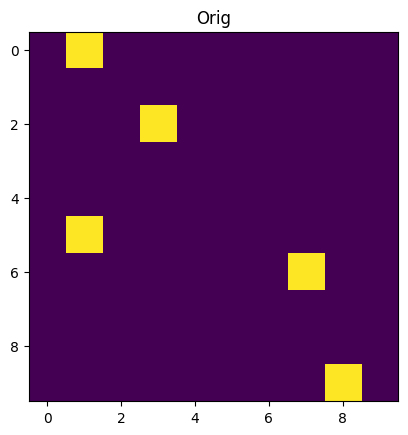

In [107]:
test = np.zeros((10,10))
test[(0, 1)] = 255
test[(2, 3)] = 255
test[(5, 1)] = 255
test[(6, 7)] = 255
test[(9, 8)] = 255

plt.imshow(test)
plt.title("Orig")
plt.axis(True)
plt.show()

In [111]:
mapped = storeVals(test)
print(mapped)
random.shuffle(mapped)
print(mapped)

[(0, 1), (2, 3), (5, 1), (6, 7), (9, 8)]
[(6, 7), (5, 1), (0, 1), (2, 3), (9, 8)]


In [164]:
def randShuffleMethod(cp):
    cp_img = np.copy(cp)
    plt.imshow(cv2.cvtColor(cp_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis(False)
    plt.show()    
    
    edge = cv2.Canny(cp_img, 20, 170,  L2gradient = True)
    plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
    plt.title("Canny Edge Filtered Image")
    plt.axis(False)
    plt.show()
    
    filt = pixelWipe(edge, 0.01)
    plt.imshow(cv2.cvtColor(filt, cv2.COLOR_BGR2RGB))
    plt.title("Filtered")
    plt.axis(False)
    plt.show()
    
    mapped = storeVals(filt)
    random.shuffle(mapped)
    
    filt1 = np.copy(filt)
    filt2 = np.copy(filt)
    for i in range(1, len(mapped)):
        filt1 = drawLine(filt1, mapped[i-1], mapped[i])
        filt2 = connectLines(filt2, mapped[i-1], mapped[i])
    plt.imshow(cv2.cvtColor(filt1, cv2.COLOR_BGR2RGB))
    plt.title("Str Line")
    plt.axis(False)
    plt.show()
    plt.imshow(cv2.cvtColor(filt2, cv2.COLOR_BGR2RGB))
    plt.title("Rand Line")
    plt.axis(False)
    plt.show()
    
    

In [214]:
def nearMethod(cp, cut, l_thr, h_thr):
    cp_img = np.copy(cp)
    plt.imshow(cv2.cvtColor(cp_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis(False)
    plt.show()    
    
    edge = cv2.Canny(cp_img, l_thr, h_thr,  L2gradient = True)
    plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
    plt.title("Canny Edge Filtered Image")
    plt.axis(False)
    plt.show()
    
    filt = pixelWipe(edge, cut)
    plt.imshow(cv2.cvtColor(filt, cv2.COLOR_BGR2RGB))
    plt.title("Filtered")
    plt.axis(False)
    plt.show()
    
    maxDist = math.dist((0,0), cp_img.shape[:-1])
    # print(distMax)
    mapped = storeVals(filt)
    
    first = random.choice(mapped)
    mapped.remove(first)
    
    filt1 = np.copy(filt)
    filt2 = np.copy(filt)
    
    while(mapped):
        second = random.choice(mapped)
        count = 0
        while (count < 500):
            if math.dist(first, second) < maxDist*0.001*count:
                break
            second = random.choice(mapped)
            count += 1

        mapped.remove(second)
        filt1 = drawLine(filt1, first, second)
        filt2 = connectLines(filt2, first, second)
        first = second
        
    
    plt.imshow(cv2.cvtColor(filt1, cv2.COLOR_BGR2RGB))
    plt.title("Str Line")
    plt.axis(False)
    plt.show()
    plt.imshow(cv2.cvtColor(filt2, cv2.COLOR_BGR2RGB))
    plt.title("Rand Line")
    plt.axis(False)
    plt.show()
    
    

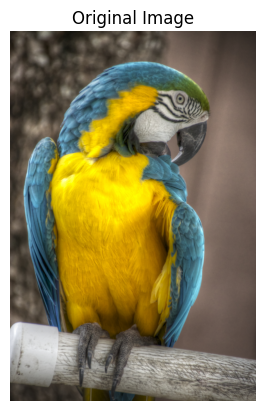

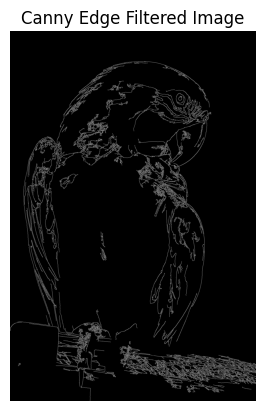

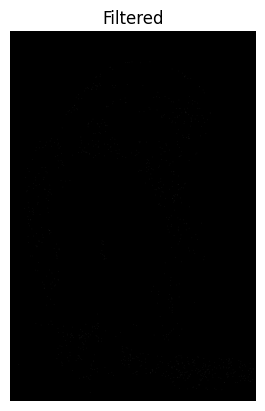

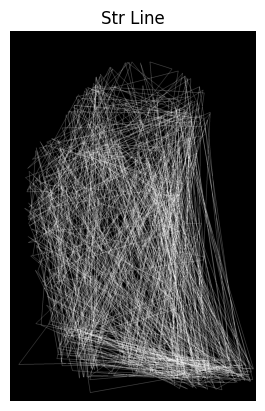

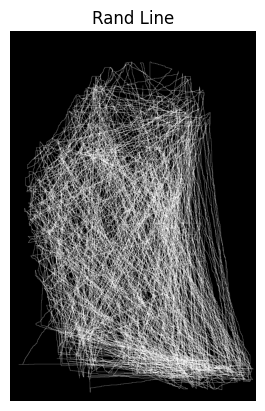

In [196]:
randShuffleMethod(img)

In [129]:
a = [1,2,3,4,5]

b = random.choice(a)
a.remove(b)
print(a)
print(b)

[1, 2, 3, 5]
4


In [134]:
a = (1,2)

print(a[1])

2


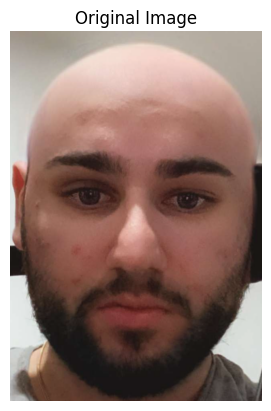

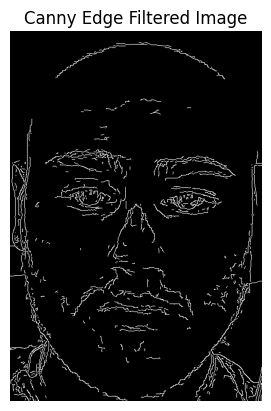

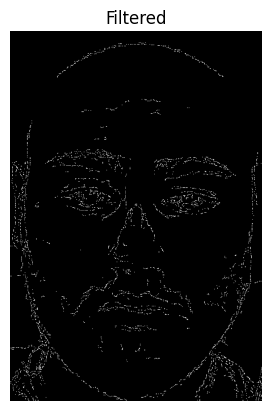

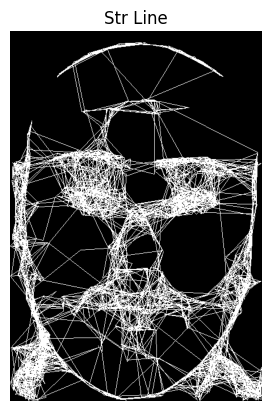

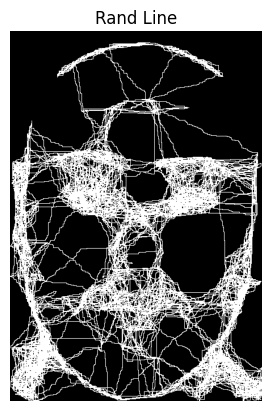

In [216]:
nearMethod(img, 0.4, 55, 40)